# K-means clustering

K-means is a simple clustering algorithm. In this case we are in an unsupervised setup, meaning that we don't have classes or output labels for our data, but we want to cluster in a way that data belonging to a cluster are similar to each other, and different from data belonging to other clusters.

In this notebook we'll take your through an example to see how this is done in practice. First we'll start by showing you some steps to take when first exploring your data. Then, we'll show the K-means clustering algorithm and will decide what's the best number of clusters to choose. Let's start by importing the necessary libraries. If you're not familiar with jupyter notebooks: Hold "Shift" then press "Enter" to execute and move to the next cell. 

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
from scipy.cluster.vq import vq, kmeans, whiten
from sklearn import preprocessing

from sklearn.cluster  import KMeans, MiniBatchKMeans
from mpl_toolkits.mplot3d import Axes3D

from IPython.display  import Image as display_image
from scipy.spatial.distance import cdist

%matplotlib inline  

During this exercises we will use a dataset containing information on wines. We want to discover clusters of different types of wine, and we have data on the wines' chemical characteristics. The data is the result of chemical analysis of wines grown in the same region in Tuscany, Italy but derived from different cultivars. The analysis determined the quantities of 13 constituents found in each wine. We want to see whether we can detect patterns in the data, such that we are able to cluster the wines together into distinct types. 

Our data consists of the following features:

1. Alcohol 
2. Malic acid 
3. Ash 
4. Alcalinity of ash 
5. Magnesium 
6. Total phenols 
7. Flavanoids 
8. Nonflavanoid phenols 
9. Proanthocyanins 
10. Color intensity 
11. Hue 
12. OD280/OD315 of diluted wines 
13. Proline 

As this is a clustering exercises, we don't have any pre-determined classes to classify the wine, but we will try and detect those in our data. Let's get started...

Let's start by reading in our data, we'll use unlabeled wine data for this: 

In [2]:
df=pd.read_csv('wine_data_nolabels.csv')
df.head()

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Our data is now stored in Pandas dataframe called df. As you can see our data consists of chemical measures of each wine. I wonder how many different wines there are in total in our data...?

In [3]:
df.shape

(178, 13)

# Exploring our data

Alright, that's a useful to know. So we're looking at 178 different wines, and we have 13 different features, i.e. chemical measurements on them. Before we dive into the clustering, let's do a little bit of exploration of our data to see whether there are things that look weird/suspicious etc. You could start by doing the following:

In [4]:
df.describe()

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


OK, getting a massive table of summary statistics might seem like a good starting point, but it's not actually very informative just by glancing at it. It might be a better idea to create a few informative graphs. Before we do that, we want to transform our data into an NumPy array. 

Now hold on... why on earth do we want to convert our data to a NumPy array? Well, it turns out that the NumPy array data structure holds some benefits over Python lists and Pandas dataframes, such as: being more compact, faster access in reading and writing items, being more convenient and more efficient. Moreover the NumPy library has a huge amount of high-level mathematical functions we can use on its' arrays. So think of these arrays as a powerful data structure for efficient computation, which are excellent to use for things like Machine Learning which is why they are heavily used in implementations of ML algorithms. 

In [5]:
# this is an easy way to do it, let's store our features in an array called X
X=np.array(df).astype(float)
# and we'll save those column names, they will come in handy later
header = df.columns

### Scatter plots 

In the following cell we'll create a bunch of graphs. These are bi-variate scatterplots of the individual features in our data. We'll get a feel for how our features relate to each other, and we might be able to eye-ball correlations between features. 

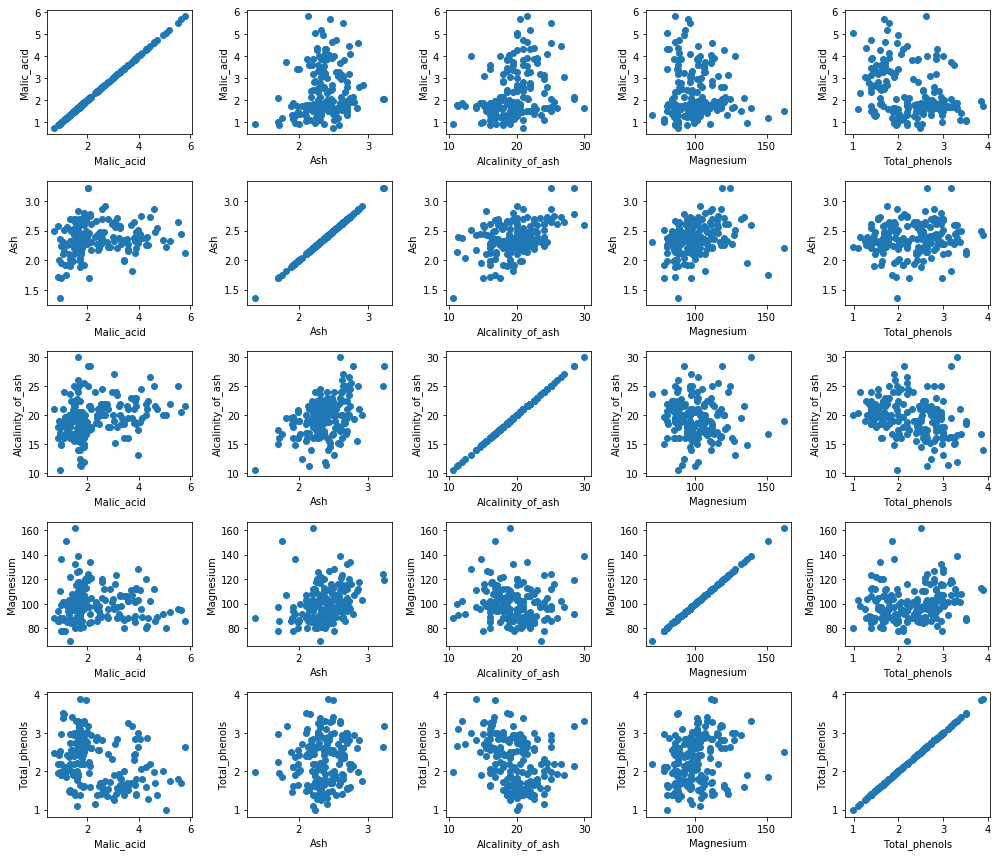

In [6]:
fig = plt.figure(figsize=(14,12))
feat_comb_1 = [1,2,3,4,5]
feat_comb_2 = [1,2,3,4,5]
#This next line was alluded to above, it essentially gives the transpose of X
feature_array = [X[:,j] for j in range(len(header))]

nfeat = len(feat_comb_1)

for j in range(nfeat):
    for k in range(nfeat):
        #subplot takes 3 arguments. 
        # If the final plot is going to be 4 subplots x 4 subplots for example, 
        # both of these arguments must be equal to 4. 
        # The third argument should be incremented sequentially and matplotlib will then decide, for example
        # that in the case of a 5x5 matrix of plots, the 9th plot should be in the 4th plot on the second row
        plt.subplot(nfeat, nfeat, j + 1 + k * nfeat)
        plt.scatter(feature_array[feat_comb_1[j]], feature_array[feat_comb_2[k]])
        plt.xlabel(header[feat_comb_1[j]])
        plt.ylabel(header[feat_comb_2[k]])
        fig.tight_layout()

Do you find that there are any particular patterns in our data? 

### Boxplots 
We can also make that df.describe() command a bit easier on the eye. You could for example plot box-plots of each feature in the same plot, so you can visually look at things like mean, outliers, distributions etc in one go. Let's give it a try below

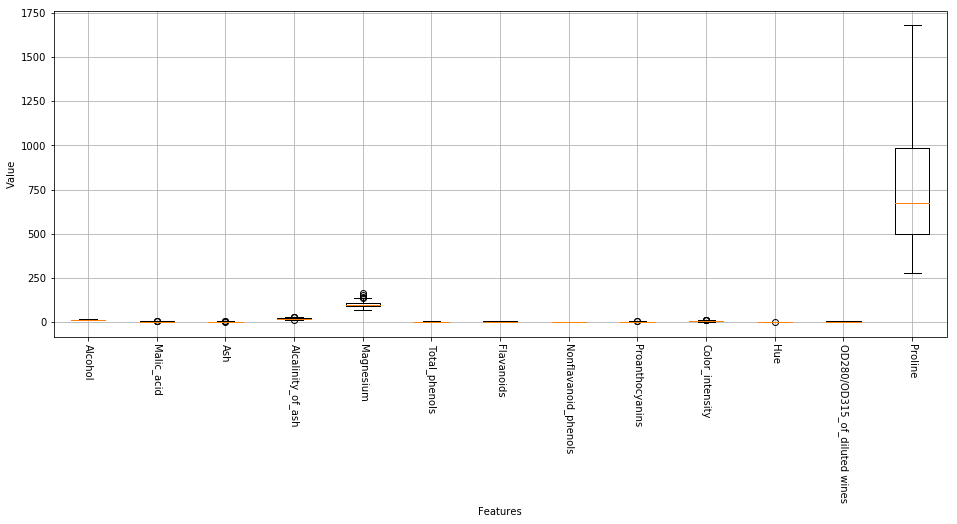

In [7]:
fig, axes = plt.subplots(figsize=(16,6))
bp = plt.boxplot(X)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='o')
plt.xlabel('Features')
plt.ylabel('Value')
axes.set_xticklabels(header, rotation=270)
plt.grid()

Uuuuh...right. This graph looks terrible and is not very informative. What is the problem here do you think? We'll address it in a second below


### Correlations

Numpy contains the function "corrcoef" which allows you to calculate the NxN correlations matrix of an NxM feature matrix. That means that you can look at all correlations between our features in one easy step, without having to eyeball it from scatterplots like we did before. 
Let's have a look at a selection of features stored in our numpy array X. We'll calculate the correlation matrix, and will plot the matrix as a heatmap. 

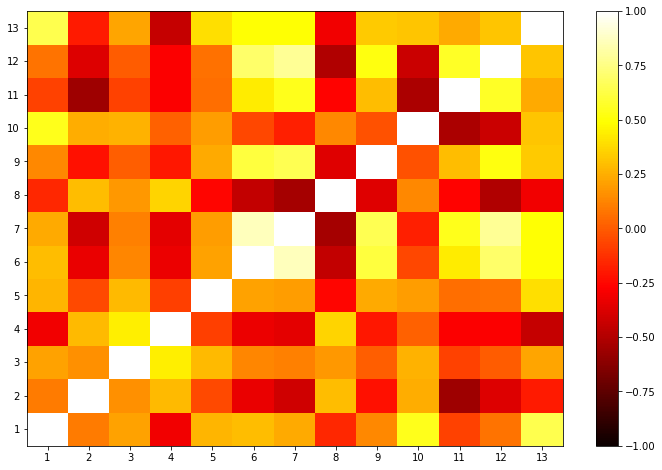

In [8]:
fig = plt.figure(figsize=(12,8))
correlationMatrix = np.corrcoef(X, rowvar=0)

#A nice way to visualise the correlations matrix is to make a scatterplot and rather than write values, assign a colour map
plt.pcolor(correlationMatrix, cmap = 'hot', vmin=-1, vmax=1)
plt.colorbar()

# put the major ticks at the middle of each cell
plt.yticks(np.arange(0.5, 13.5), range(1,14))
plt.xticks(np.arange(0.5, 13.5), range(1,14))

plt.show()

Do you understand how to interpret this graph?

### Feature scaling

Remember that ugly boxplot graph earlier? You might have understood that our features are all on different scales. This will become problematic when trying to cluster our data. Often when dealing with real data, it is wise to normalise it. For example, if we are looking at one feature whose mean is 100 and another whose mean is 0.0001, it is difficult to compare a measurement of these two features. 

More generally, features scaling is pretty much always necessary if you want to run a complex machine learning algorithm. If we would ignore the different scales, the ML optimization problem will take very long to solve. To make sure all our features are on the same scale, you could apply a function to feature scale our features. (Don't worry you can also do this with Scikit-learn, but it's good to understand how feature scaling works). 

A good function to scale features would be:

$$x_i = \frac{x_i - \mu_i}{std(x_i)}$$

You can use mean() and max() operators built into pandas to do this.
The function should return both the scaled input vector, as well as the mean and standard deviation to be used to scale future samples.
 
Then there is preprocessingin Scikit-learn. Python's preprocessing module can transform the data, meaning we don't have to go through the arduous steps of calculating the mean and standard deviation and then applying the transformation manually. Whether you want to normalise in the sense that the mean in all features is zero, the variance is unity, or both, all of these options are available by setting the optional arguments: "with_mean=True/False" and  "with_std=True/False" as required. For more information, see http://scikit-learn.org/stable/modules/preprocessing.html

Let me show you how to do this for our data X:

In [9]:
scaler  = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In order to check whether that actually worked, let's plot those boxplots again.

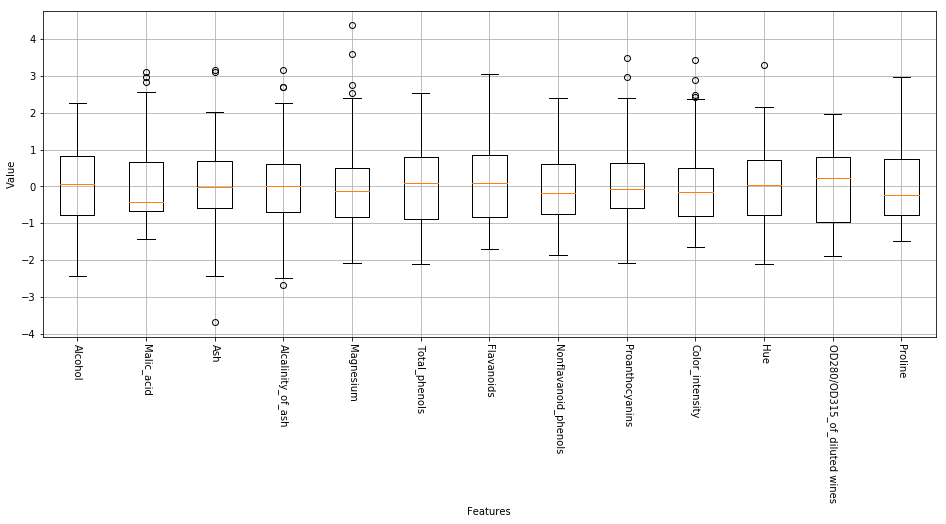

In [10]:
fig, axes = plt.subplots(figsize=(16,6))
bp = plt.boxplot(X_scaled)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='o')
plt.xlabel('Features')
plt.ylabel('Value')
axes.set_xticklabels(header, rotation=270)
plt.grid()

OK that's much nicer. Now that we've explored our data and have scaled our features, we're ready for some clustering...

# K-means clustering 


The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing some measure of distance between the data points and cluster centroids.
Sci-kit learn's implementation of K-means basically calculates the "Sum of distances of samples to their closest cluster center" and calls this "inertia"

This algorithm requires the number of clusters to be specified beforehand. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

The k-means algorithm divides a set of N samples X into K disjoint clusters C, each described by the mean $m_j$ of the samples in the cluster. The means are commonly called the cluster “centroids”; The K-means algorithm aims to choose centroids that minimise the inertia (measure of distance), or within-cluster sum of squared criterion. 

You can read more about it here:
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

or here: 
http://scikit-learn.org/stable/modules/clustering.html#k-means


The k-means algorithm adjusts the centroids until sufficient progress cannot be made, i.e. the change in distortion since the last iteration is less than some threshold. Let's see how this is done in practice:

In [11]:
clf = KMeans(n_clusters = 5, init='k-means++')
#the fit method in sci-kit learn libraries tends to be the one that takes an NxM array as its input
clf.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Ok great that was easy, but how on earth do I interpret this? My K-means algorithm creates a mapping from my datapoints to their closest cluster. But that still is hard to interpret. A way of trying to interpret K-means is to visualise it in a graph, using the mapping for the different cluster colors. Here's an example: 

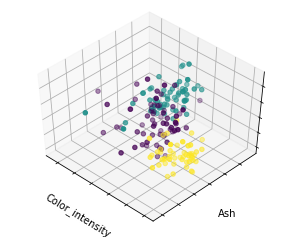

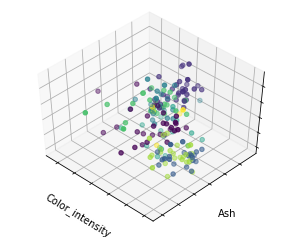

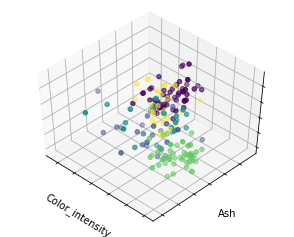

In [12]:
estimators = {'k_means_3': KMeans(n_clusters=3),
              'k_means_8': KMeans(n_clusters=8),
              'k_means_5': KMeans(n_clusters=5)
             }

fignum = 1
for name, est in estimators.items():
    fig = plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    plt.cla()
    est.fit(X_scaled)
    labels = est.labels_

    ax.scatter(X_scaled[:, 10], X_scaled[:, 3], X_scaled[:, 5], c=labels.astype(np.float))

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Color_intensity')
    ax.set_ylabel('Ash')
    ax.set_zlabel('Magnesium')
    fignum = fignum + 1

Can you see from these graphs what a good amount of clusters should be? 

Extra points for this **Question:** why do you think I chose Colour intensity, Ash and Magnesium to plot the figure? I could have chosen 3 other features. Perhaps go back to the data exploration part to find clues!

You could try and play around changing the features I select for plotting with this line: 

ax.scatter(X_scaled[:, 10], X_scaled[:, 3], X_scaled[:, 5], c=labels.astype(np.float))

### Initializing your algorithm; the good, the bad and the ugly
You might have noticed that we set a value for "init" before. This was to make you aware of this. Remember, we first wrote "clf = KMeans(n_clusters = 3, init='k-means++')"

The value for init, can be ‘k-means++’, ‘random’ or an ndarray
Its bascially the settings for Method for initialization of the algorithm, and it defaults to ‘k-means++’. This is a pretty important part of the algorithm in fact. 

Given enough time, K-means will always converge, however this may be to a local minimum. This is highly dependent on the initialization of the centroids and the way we set it. As a result, it's best to do the computation often and several times, with different initializations of the centroids. One method to help address this issue is the k-means++ initialization scheme, which has been implemented in scikit-learn (use the init='kmeans++' parameter). This initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization,

The way the documentation describes it: 

‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 

‘random’: choose k observations (rows) at random from data for the initial centroids.

The number of times the k-means algorithm will be run with different centroid seeds is refered to as n_init, the default value is 10, and as we said before it's best to do it a couple of times. With multiple runs, the final results will be the best output of n_init consecutive runs in terms of inertia (measure of distance). In practice, the k-means algorithm is very fast (one of the fastest clustering algorithms available), but it falls in local minima. That’s why it can be useful to restart it several times.

Here are some examples for good and bad practices: 

In [13]:
#'k_means_bad_init' 
KMeans(n_clusters=3, n_init=1, init='random')

# Why is this bad?

#'k_means_good_init'
KMeans(n_clusters=3, init='k-means++')

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

** Question:** What's bad about the first set-up? Why is the second one better? What about the default values, are they any good? (If you can't answer this go back and read the section above)

### K-means for large datasets

When you're doing K-means on a very large dataset, the algorithm can sometimes be somewhat slow. A way to solve this is to use a method called MiniBatchKMeans

MiniBatchKMeans is an alternative online implementation that does incremental updates of the centers positions using mini-batches. For large scale learning (say n_samples > 10k) MiniBatchKMeans is probably much faster than the default batch implementation.

See also: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans

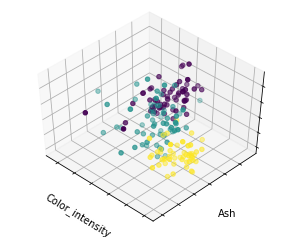

In [14]:
clf=MiniBatchKMeans(n_clusters=3, init='k-means++')
clf.fit(X_scaled)
labels = clf.labels_

fig = plt.figure(figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X_scaled[:, 10], X_scaled[:, 3], X_scaled[:, 5], c=labels.astype(np.float))
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Color_intensity')
ax.set_ylabel('Ash')
ax.set_zlabel('Magnesium')


You see, it gives the same results but on large data this is generally much quicker

### Elbow Curves and Choosing K

How can we choose the right amount of clusters K?

Ideally, we want to have the smallest number of clusters that is able to separate our data in groups that are "distinct enough".

Thus let us try all K=1-10, calculate the positions of all of the centroids, and then take the average of the Euclidean distance from every point to its closest centroid and plot this vs K. 

For this exercise we'll use a slightly different way of calculating K-means, not using scikit-learn but SciPy instead. This is to show you there are more ways to implement this algorithm. 

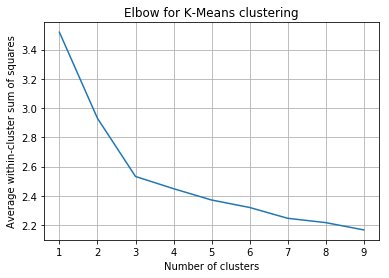

In [15]:
K = range(1,10)

#Note here we are using a different library. Previously it was sci-kit learn, no we've moved to scipy (see the top of the notebook
#where we imported KMeans and kmeans)

KM = [kmeans(X_scaled,k) for k in K] # apply kmeans 1 to 10

#the scipy method stores the result in a funny format, it stores the coordinates of all centroids and then the measure of
#average distance of all points from their closest centroid (which is what we're after)

distances=[KM[i][1] for i in range(len(KM))]

plt.plot(range(1,10),distances)
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering') 

For a slightly less "black box" way of doing this, we can run a loop over all desired values of K, fitting the model (using sci-kit learn this time) for each K seperately. We then calculate the "labels" for each data point (i.e. which cluster it belongs to or which centroid it is closest to). Then we compute the Euclidean distance from each point to its closest centroid and take the average. 

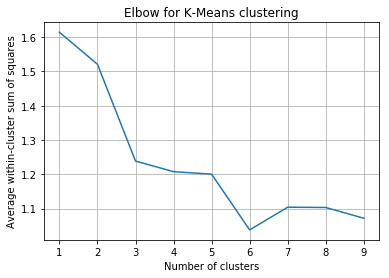

In [16]:
centroids=[[] for i in range(1,10)]
euclidean_distances=[0 for i in range(len(X_scaled))]
cluster_averaged_distances=[0 for i in range(1,10)]

for K in range(1,10):
    clf = KMeans(n_clusters = K, init='k-means++')
    clf.fit(X_scaled.astype(float))
    labels= clf.predict(X_scaled)
    
    centroids= clf.cluster_centers_ 
    
    for j in range(len(X_scaled)):
        euclidean_distances[j]=0
        cluster=labels[j]
        for k in range(3):
            euclidean_distances[j]+=(X_scaled[j][k]-centroids[cluster][k])**2
        euclidean_distances[j]=(euclidean_distances[j])**0.5

    cluster_averaged_distances[K-1]=np.mean(euclidean_distances)
               
plt.plot(range(1,10),cluster_averaged_distances)
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

The above is substantially slower than using sci-py because running all of these loops isn't well optimised. Sci-kit learn has a similar method for calculating the "Sum of distances of samples to their closest cluster center", but it calculates the sum of the squared Euclidean distances, rather than the sum of the roots, meaning the answer is somewhat different than that obtained using scipy (if we take the square root at the end, it brings us to the same ballpark but $\Sigma_{i}\sqrt{x_{i}}\neq \sqrt{\Sigma_{i}x_{i}}$). Nonetheless, this is a completely valid metric, it's up to you which you'd prefer to use.

Lastly, you can also calculate a different distance metric than Euclidian distance. Why should you care about different distance metrics? Well, your results and choice of K can actually depend on the distance metric you chose. Here is an example of using the squared distance to create the same graph as above. Do you notice how things look different?

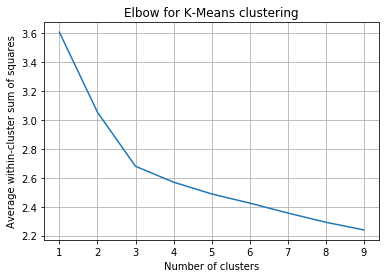

In [17]:
squared_distances=[]
for k in range(1,10):
    clf = KMeans(n_clusters = k, init='k-means++')
    clf.fit(X_scaled.astype(float))
    squared_distances.append((clf.inertia_/len(X_scaled))**0.5)
    
plt.plot(range(1,10),squared_distances)
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

**Question:** Based on the three graphs you've seen, what would your choice of K be for this data?

Copyright © SherlockML 2017 All rights reserved